In [1]:
!pip install -q imbalanced-learn xgboost tensorflow

# STEP 1) Import the required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

print("All the required packages are imported")

All the required packages are imported


In [2]:
# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Step 2: Load your local dataset

df = pd.read_csv("Churn_Modelling.csv")
print("Dataset loaded successfully")

Dataset loaded successfully


In [3]:
# Step 3: Explore the dataset # BASIC EDA: structure & stats
print("✅ Dataset Loaded Successfully!\n")
print("Shape of dataset:", df.shape)
print("\nFirst 5 rows:\n", df.head())
print("\nDataset Info:\n")
print(df.info())
print("\nSummary Statistics:\n", df.describe())

✅ Dataset Loaded Successfully!

Shape of dataset: (10000, 14)

First 5 rows:
    RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58    


Missing Values in Each Column:
 RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


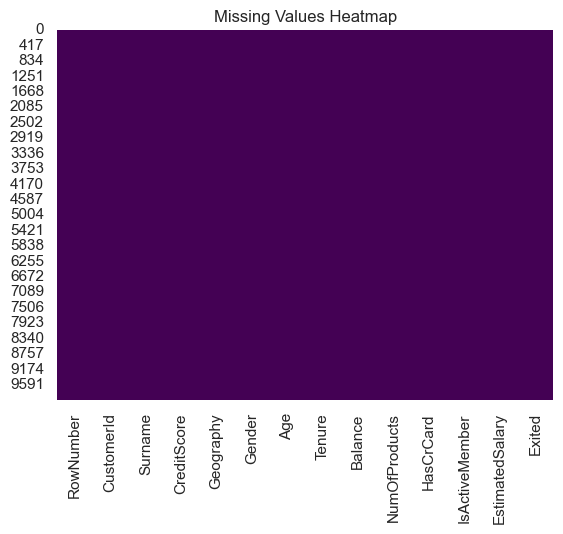

In [4]:
# Step 4: Check for missing values
print("\nMissing Values in Each Column:\n", df.isnull().sum())
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

In [5]:
#Step5 Encoding Categorical Variables
df_encoded = df.copy()

le = LabelEncoder()
df_encoded['Gender'] = le.fit_transform(df_encoded['Gender'])

df_encoded = pd.get_dummies(df_encoded, columns=['Geography'], drop_first=True)
df_encoded.head()

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,2,15647311,Hill,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,3,15619304,Onio,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False
3,4,15701354,Boni,699,0,39,1,0.00,2,0,0,93826.63,0,False,False
4,5,15737888,Mitchell,850,0,43,2,125510.82,1,1,1,79084.10,0,False,True



STEP 6: Detailed EDA - plotting key relationships


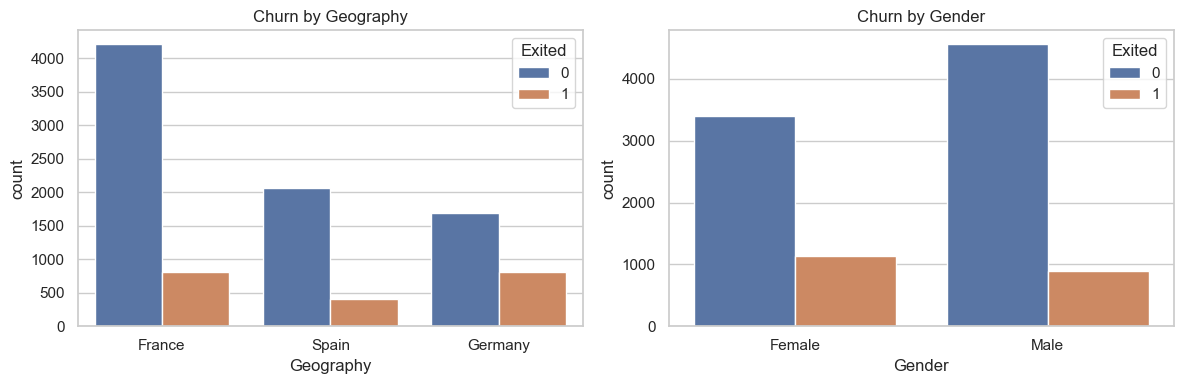

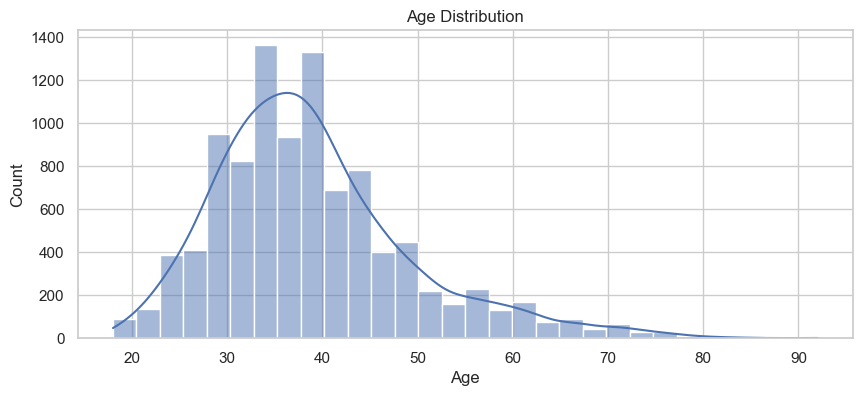

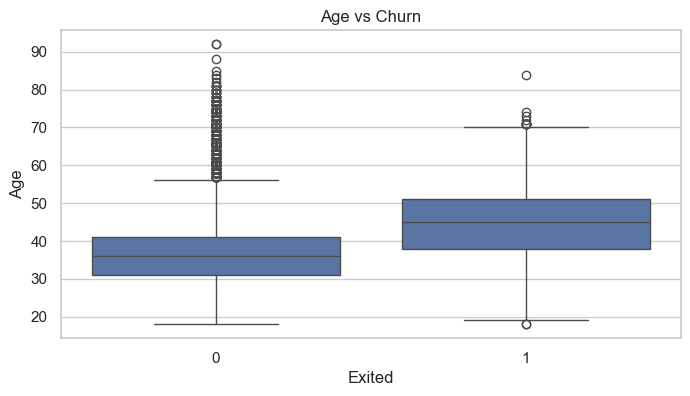

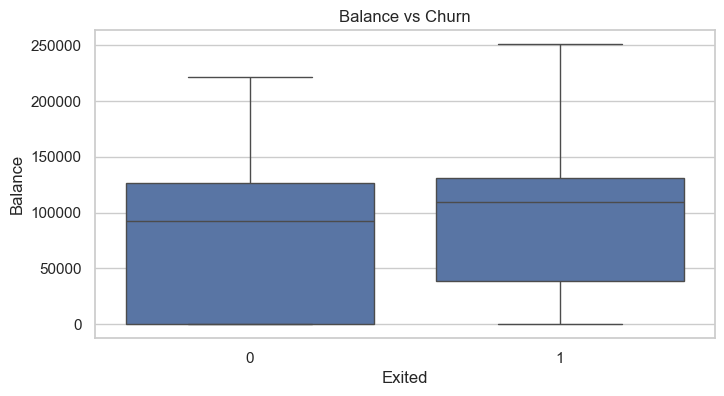

In [6]:
#Step 6 EDA analysis (Visuals)
print("\nSTEP 6: Detailed EDA - plotting key relationships")

# Churn by Geography & Gender

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(x='Geography', hue='Exited', data=df)
plt.title('Churn by Geography')
plt.subplot(1,2,2)
sns.countplot(x='Gender', hue='Exited', data=df)
plt.title('Churn by Gender')
plt.tight_layout()
plt.show()

# Age distribution and churn by age
plt.figure(figsize=(10,4))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x='Exited', y='Age', data=df)
plt.title('Age vs Churn')
plt.show()

# Balance vs Exited
plt.figure(figsize=(8,4))
sns.boxplot(x='Exited', y='Balance', data=df)
plt.title('Balance vs Churn')
plt.show()

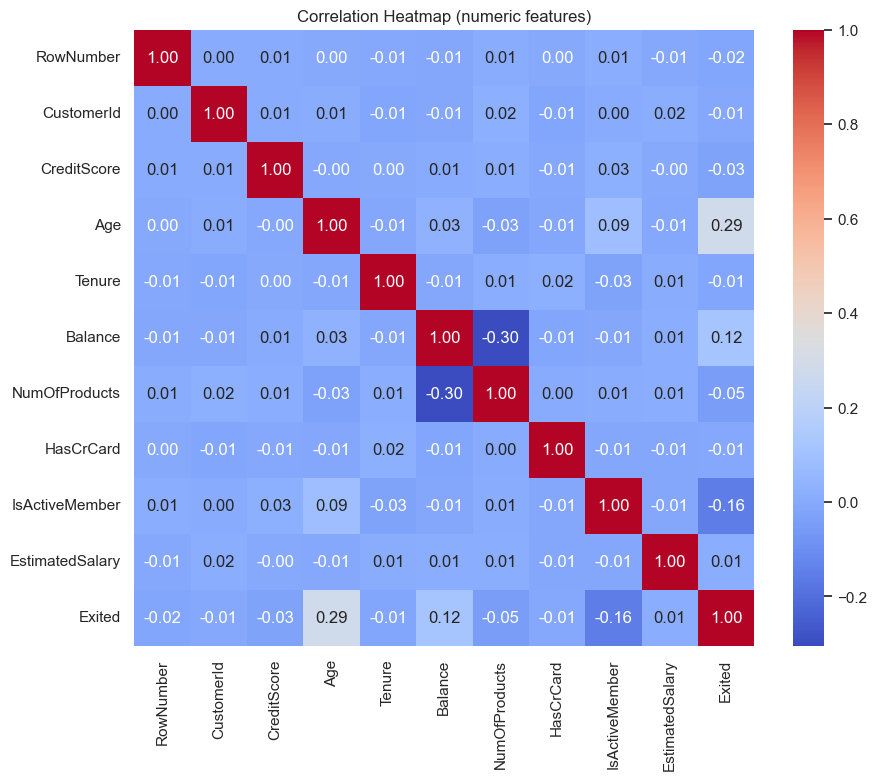

STEP 7 COMPLETED: EDA visuals done


In [7]:
#Step 7 Correaltion Analysis
# Correlation heatmap (numeric features)
num_cols = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap (numeric features)")
plt.show()
print("STEP 7 COMPLETED: EDA visuals done")

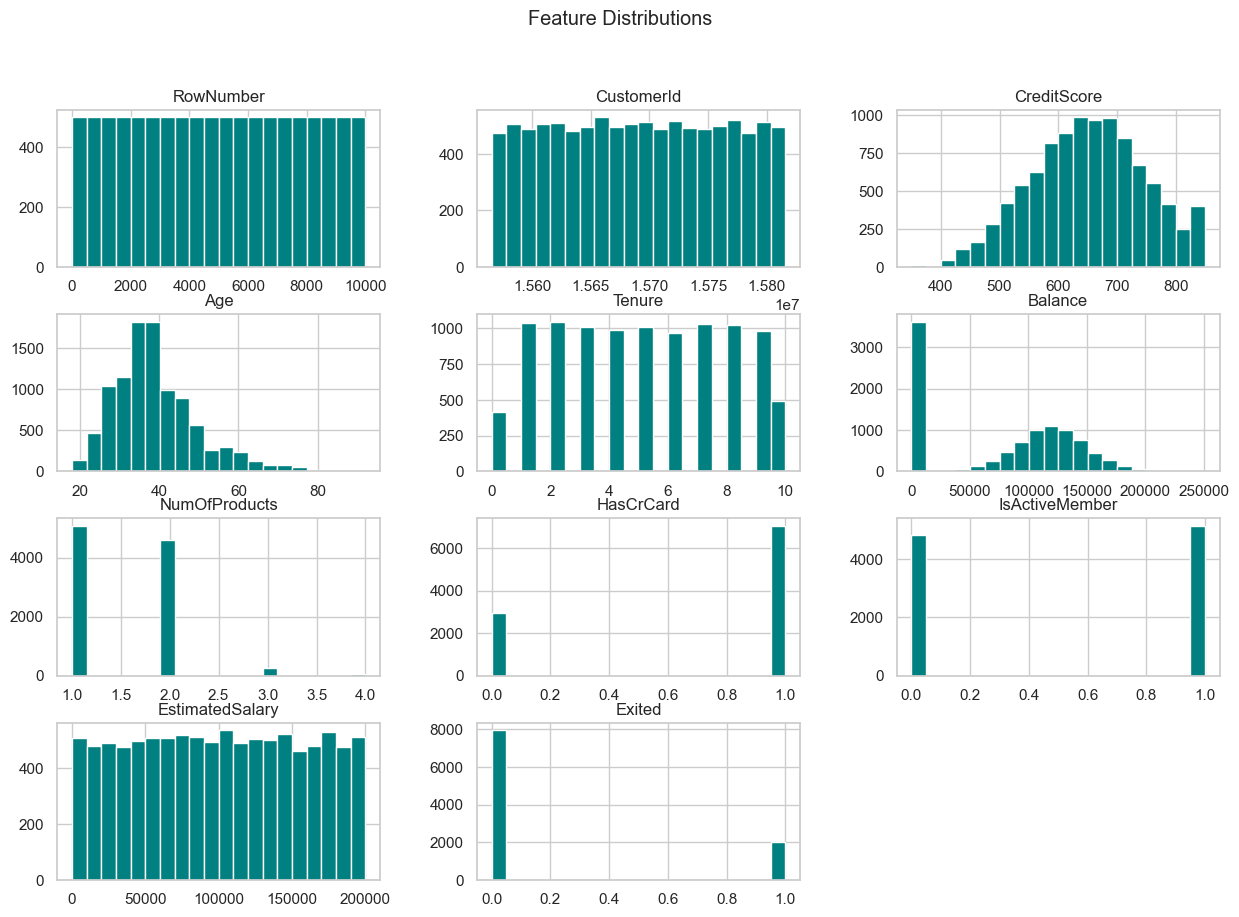

In [8]:
# Step 8: Feature distributions
df.hist(bins=20, figsize=(15, 10), color='teal')
plt.suptitle("Feature Distributions")
plt.show()

In [9]:
print("Actual class count")
print("Find the class count to apply the balance ")
# Count how many samples in each class
class_count = df['Exited'].value_counts()
print("Class count:")
print(class_count)

Actual class count
Find the class count to apply the balance 
Class count:
Exited
0    7963
1    2037
Name: count, dtype: int64



STEP 6: Feature engineering - creating new features
Feature columns added. Sample:


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,AgeGroup,TenureBucket,CreditScoreBucket,HighBalanceFlag,MultipleProducts,Age_Balance_interaction,LowSalary_HighBalance
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,35-49,2-3,Med,0,0,42.00,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.744677,35-49,0-1,Med,0,0,3436163.26,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.401375,35-49,7-10,Low,1,1,6705795.60,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,35-49,0-1,High,0,1,39.00,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1.587055,35-49,2-3,VeryHigh,1,0,5397008.26,1



STEP 6 COMPLETED: Feature engineering done


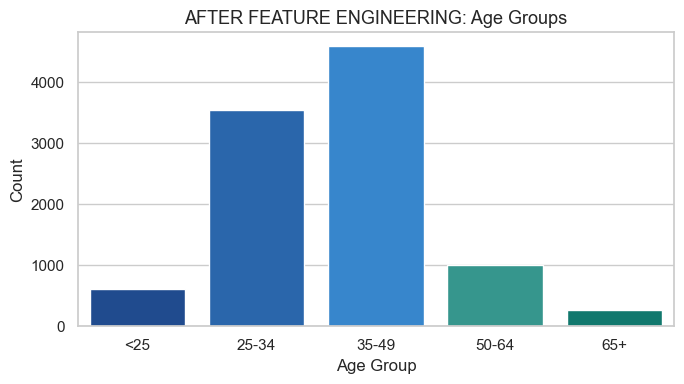

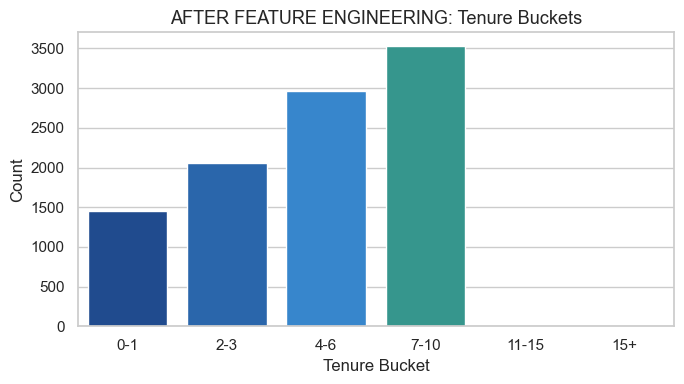

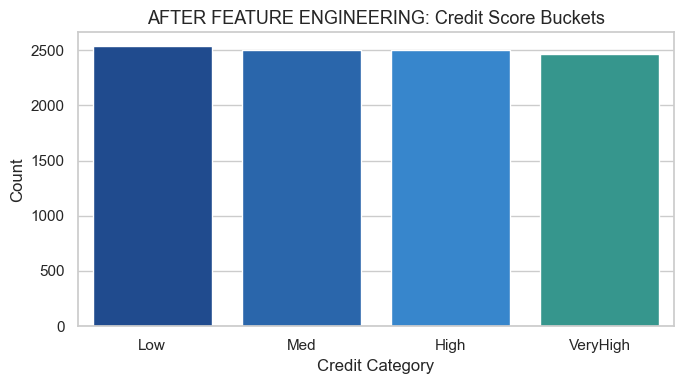

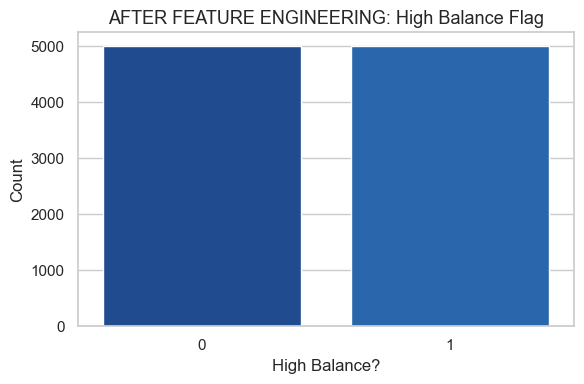

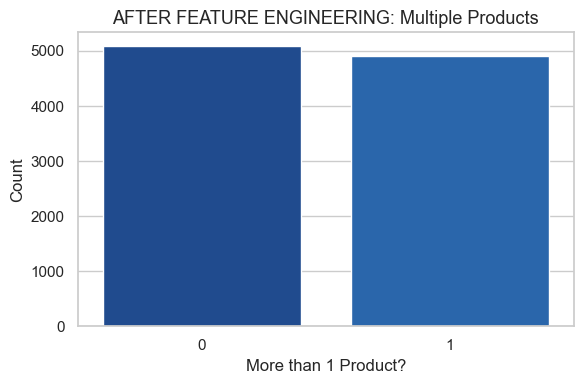

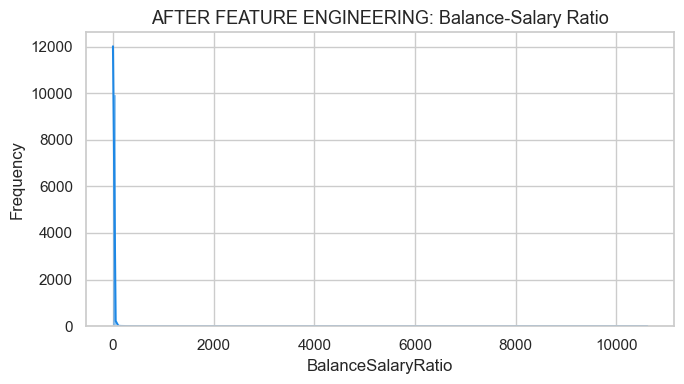

In [10]:
# ============================================================
# STEP 6: FEATURE ENGINEERING + VISUALS (PREMIUM COLOUR PALETTE)
# ============================================================

print("\nSTEP 6: Feature engineering - creating new features")

import seaborn as sns
import matplotlib.pyplot as plt

# Custom visually appealing palette (Ocean + Teal + Royal Blue)
premium_palette = sns.color_palette(
    ["#0D47A1", "#1565C0", "#1E88E5", "#26A69A", "#00897B"]
)

sns.set(style="whitegrid", palette=premium_palette)


# ------------------------------------------------------------
# 6.1 DROP USELESS IDs
# ------------------------------------------------------------
df_fe = df.copy()
for col in ['RowNumber', 'CustomerId', 'Surname']:
    if col in df_fe.columns:
        df_fe.drop(columns=col, inplace=True)


# ------------------------------------------------------------
# 6.2 BALANCE / SALARY RATIO
# ------------------------------------------------------------
df_fe['BalanceSalaryRatio'] = df_fe.apply(
    lambda r: r['Balance'] / (r['EstimatedSalary'] + 1e-9), axis=1
)


# ------------------------------------------------------------
# 6.3 AGE GROUPS
# ------------------------------------------------------------
age_bins = [0, 25, 35, 50, 65, 120]
age_labels = ['<25', '25-34', '35-49', '50-64', '65+']
df_fe['AgeGroup'] = pd.cut(df_fe['Age'], bins=age_bins, labels=age_labels)


# ------------------------------------------------------------
# 6.4 TENURE BUCKETS
# ------------------------------------------------------------
tenure_bins = [-1, 1, 3, 6, 10, 15, 100]
tenure_labels = ['0-1', '2-3', '4-6', '7-10', '11-15', '15+']
df_fe['TenureBucket'] = pd.cut(df_fe['Tenure'], bins=tenure_bins, labels=tenure_labels)


# ------------------------------------------------------------
# 6.5 CREDIT SCORE BUCKETS
# ------------------------------------------------------------
df_fe['CreditScoreBucket'] = pd.qcut(
    df_fe['CreditScore'], q=4,
    labels=['Low', 'Med', 'High', 'VeryHigh']
)


# ------------------------------------------------------------
# 6.6 HIGH BALANCE FLAG
# ------------------------------------------------------------
median_bal = df_fe['Balance'].median()
df_fe['HighBalanceFlag'] = (df_fe['Balance'] > median_bal).astype(int)


# ------------------------------------------------------------
# 6.7 MULTIPLE PRODUCTS FLAG
# ------------------------------------------------------------
df_fe['MultipleProducts'] = (df_fe['NumOfProducts'] > 1).astype(int)


# ------------------------------------------------------------
# 6.8 INTERACTION: AGE × BALANCE
# ------------------------------------------------------------
df_fe['Age_Balance_interaction'] = df_fe['Age'] * (df_fe['Balance'] + 1)


# ------------------------------------------------------------
# 6.9 LOW SALARY + HIGH BALANCE FLAG
# ------------------------------------------------------------
df_fe['LowSalary_HighBalance'] = (
    (df_fe['EstimatedSalary'] < df_fe['EstimatedSalary'].median()) &
    (df_fe['Balance'] > df_fe['Balance'].median())
).astype(int)


print("Feature columns added. Sample:")
display(df_fe.head())

print("\nSTEP 6 COMPLETED: Feature engineering done")


# ============================================================
# STATIC VISUALS – AFTER FEATURE ENGINEERING
# ============================================================

# ---- 1. AgeGroup Count ----
plt.figure(figsize=(7,4))
sns.countplot(data=df_fe, x='AgeGroup', palette=premium_palette)
plt.title("AFTER FEATURE ENGINEERING: Age Groups", fontsize=13)
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---- 2. Tenure Bucket ----
plt.figure(figsize=(7,4))
sns.countplot(data=df_fe, x='TenureBucket', palette=premium_palette)
plt.title("AFTER FEATURE ENGINEERING: Tenure Buckets", fontsize=13)
plt.xlabel("Tenure Bucket")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---- 3. Credit Score Buckets ----
plt.figure(figsize=(7,4))
sns.countplot(data=df_fe, x='CreditScoreBucket', palette=premium_palette)
plt.title("AFTER FEATURE ENGINEERING: Credit Score Buckets", fontsize=13)
plt.xlabel("Credit Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---- 4. High Balance Flag ----
plt.figure(figsize=(6,4))
sns.countplot(data=df_fe, x='HighBalanceFlag', palette=premium_palette)
plt.title("AFTER FEATURE ENGINEERING: High Balance Flag", fontsize=13)
plt.xlabel("High Balance?")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---- 5. Multiple Products Flag ----
plt.figure(figsize=(6,4))
sns.countplot(data=df_fe, x='MultipleProducts', palette=premium_palette)
plt.title("AFTER FEATURE ENGINEERING: Multiple Products", fontsize=13)
plt.xlabel("More than 1 Product?")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---- 6. BalanceSalaryRatio Distribution ----
plt.figure(figsize=(7,4))
sns.histplot(df_fe['BalanceSalaryRatio'], kde=True, color="#1E88E5")
plt.title("AFTER FEATURE ENGINEERING: Balance-Salary Ratio", fontsize=13)
plt.xlabel("BalanceSalaryRatio")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [11]:
print("\nSTEP 9: Encoding categorical variables")

# Label encode Geography and Gender (we keep for tree models,  one-hot for others)
le_geo = LabelEncoder()
df_fe['Geography_LE'] = le_geo.fit_transform(df_fe['Geography'])
le_gen = LabelEncoder()
df_fe['Gender_LE'] = le_gen.fit_transform(df_fe['Gender'])

# One-hot for AgeGroup, TenureBucket, CreditScoreBucket
df_fe = pd.get_dummies(df_fe, columns=['AgeGroup','TenureBucket','CreditScoreBucket'], drop_first=True)

# Drop original Geography/Gender (we have LE)
df_fe.drop(columns=['Geography','Gender'], inplace=True)

print("Columns after encoding:", df_fe.columns.tolist()[:30])
print("STEP 9 COMPLETED: Encoding done")


STEP 9: Encoding categorical variables
Columns after encoding: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'BalanceSalaryRatio', 'HighBalanceFlag', 'MultipleProducts', 'Age_Balance_interaction', 'LowSalary_HighBalance', 'Geography_LE', 'Gender_LE', 'AgeGroup_25-34', 'AgeGroup_35-49', 'AgeGroup_50-64', 'AgeGroup_65+', 'TenureBucket_2-3', 'TenureBucket_4-6', 'TenureBucket_7-10', 'TenureBucket_11-15', 'TenureBucket_15+', 'CreditScoreBucket_Med', 'CreditScoreBucket_High', 'CreditScoreBucket_VeryHigh']
STEP 9 COMPLETED: Encoding done


In [12]:
# 10 CHECK NEGATIVE / CONSTANTs / DUPLICATES

print("\nSTEP 10: data quality checks")

# negative values check (numeric)
num_cols_fe = df_fe.select_dtypes(include=np.number).columns.tolist()
neg_check = (df_fe[num_cols_fe] < 0).any()
print("Any negative values present in numeric cols? \n", neg_check[neg_check==True])

# constant columns
constant_cols = [c for c in df_fe.columns if df_fe[c].nunique()==1]
print("Constant columns (to drop):", constant_cols)
df_fe.drop(columns=constant_cols, inplace=True, errors='ignore')

# duplicates
dupes = df_fe.duplicated().sum()
df_fe.drop_duplicates(inplace=True)
print("Duplicates found and removed:", dupes)

print("STEP 10 COMPLETED: data quality cleaned")


STEP 10: data quality checks
Any negative values present in numeric cols? 
 Series([], dtype: bool)
Constant columns (to drop): ['TenureBucket_11-15', 'TenureBucket_15+']
Duplicates found and removed: 0
STEP 10 COMPLETED: data quality cleaned


In [13]:

# 11 Prepare final X,Y

print("\nSTEP 11: Prepare final X and Y for modeling")
y = df_fe['Exited']
X = df_fe.drop(columns=['Exited'])

print("\n Final feature count:", X.shape[1])
print("\n STEP 11 COMPLETED")


STEP 11: Prepare final X and Y for modeling

 Final feature count: 25

 STEP 11 COMPLETED


Actual class count
Class count:
Exited
0    7963
1    2037
Name: count, dtype: int64


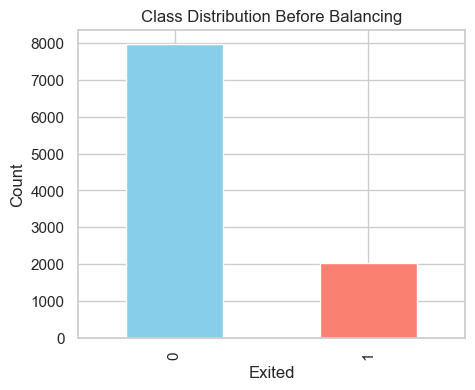

Columns used for modeling: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'BalanceSalaryRatio', 'HighBalanceFlag', 'MultipleProducts', 'Age_Balance_interaction', 'LowSalary_HighBalance', 'Geography_LE', 'Gender_LE']
Original train class distribution:
 Exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64
After SMOTE train class distribution:
 Exited
1    0.5
0    0.5
Name: proportion, dtype: float64


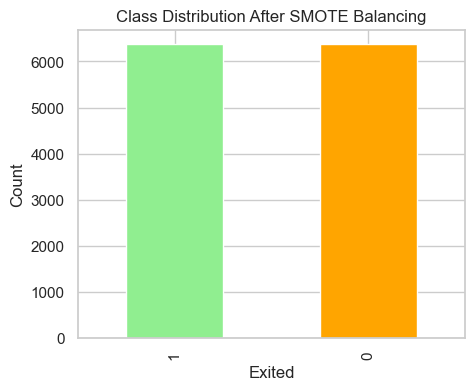

STEP 12 COMPLETED


In [14]:
# 12 SMOTE and Data Imbalancing
# Step 1 Class count on original data

print("Actual class count")
class_count = df['Exited'].value_counts()
print("Class count:")
print(class_count)

# Optional: visualize original imbalance
plt.figure(figsize=(5, 4))
class_count.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution Before Balancing')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.show()

#Step2  Features / target + numeric only

X = df_fe.drop('Exited', axis=1)
y = df_fe['Exited']

X = X.select_dtypes(include=['int64', 'float64'])
print("Columns used for modeling:", X.columns.tolist())


# Step3 Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Original train class distribution:\n",
      y_train.value_counts(normalize=True))

# Step4 SMOTE oversampling (train only)

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("After SMOTE train class distribution:\n",
      pd.Series(y_train_sm).value_counts(normalize=True))

# Optional: visualize balanced data (after SMOTE)

plt.figure(figsize=(5, 4))
pd.Series(y_train_sm).value_counts().plot(
    kind='bar', color=['lightgreen', 'orange']
)
plt.title('Class Distribution After SMOTE Balancing')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.show()

print("STEP 12 COMPLETED")


In [15]:

# 13) Feature scaling (for ANN & models needing it)

print("\nSTEP 13: Feature scaling (StandardScaler)")
scaler = StandardScaler()
# Fit scaler on training numeric columns only; if features include boolean/dummies it's still fine
X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)
print("STEP 13 COMPLETED")


STEP 13: Feature scaling (StandardScaler)
STEP 13 COMPLETED


In [16]:

# 14) Model 1 - Random Forest
# ------------------------------
print("\nSTEP 14: Training RandomForest")
#rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1)
rf = RandomForestClassifier(
    n_estimators=400,      # more trees
    max_depth=10,         # slightly deeper
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_sm, y_train_sm)
rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:,1]

print("RandomForest Evaluation:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Precision:", precision_score(y_test, rf_pred))
print("Recall:", recall_score(y_test, rf_pred))
print("F1:", f1_score(y_test, rf_pred))
print("AUC:", auc(*roc_curve(y_test, rf_prob)[:2]))
print("STEP 14 COMPLETED")


STEP 14: Training RandomForest
RandomForest Evaluation:
Accuracy: 0.8135
Precision: 0.5342741935483871
Recall: 0.6511056511056511
F1: 0.5869324473975637
AUC: 0.8456114049334389
STEP 14 COMPLETED


In [17]:
# ------------------------------
# 15) Model 2 - XGBoost
# ------------------------------
print("\nSTEP 15: Training XGBoost")
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_sm, y_train_sm)
xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)[:,1]

print("XGBoost Evaluation:")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("Precision:", precision_score(y_test, xgb_pred))
print("Recall:", recall_score(y_test, xgb_pred))
print("F1:", f1_score(y_test, xgb_pred))
print("AUC:", auc(*roc_curve(y_test, xgb_prob)[:2]))
print("STEP 15 COMPLETED")


STEP 15: Training XGBoost
XGBoost Evaluation:
Accuracy: 0.8275
Precision: 0.5665236051502146
Recall: 0.6486486486486487
F1: 0.6048109965635738
AUC: 0.8465676770761517
STEP 15 COMPLETED


In [18]:

# 16) Model 3 - ANN (Keras)
# ------------------------------
print("\nSTEP 16: Training ANN (Keras)")
input_dim = X_train_sm_scaled.shape[1]
tf.random.set_seed(42)

ann = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = ann.fit(X_train_sm_scaled, y_train_sm, validation_split=0.15, epochs=30, batch_size=128, verbose=0)
ann_prob = ann.predict(X_test_scaled).ravel()
ann_pred = (ann_prob >= 0.5).astype(int)

print("ANN Evaluation:")
print("Accuracy:", accuracy_score(y_test, ann_pred))
print("Precision:", precision_score(y_test, ann_pred))
print("Recall:", recall_score(y_test, ann_pred))
print("F1:", f1_score(y_test, ann_pred))
print("AUC:", auc(*roc_curve(y_test, ann_prob)[:2]))
print("STEP 16 COMPLETED")


STEP 16: Training ANN (Keras)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
ANN Evaluation:
Accuracy: 0.83
Precision: 0.5746102449888641
Recall: 0.6339066339066339
F1: 0.602803738317757
AUC: 0.8529854970532937
STEP 16 COMPLETED



STEP 17: Visualizations - Confusion Matrices, ROC, Feature Importance


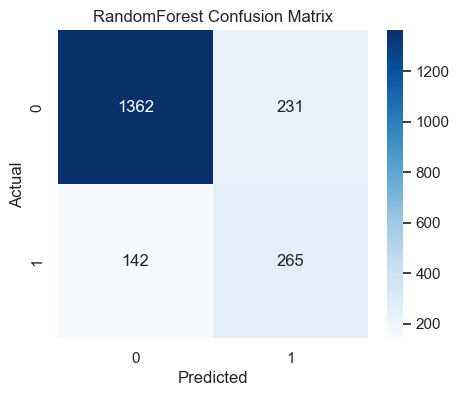

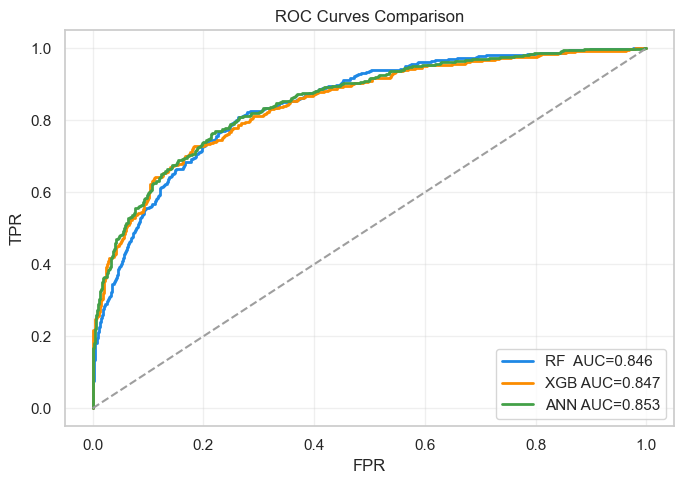

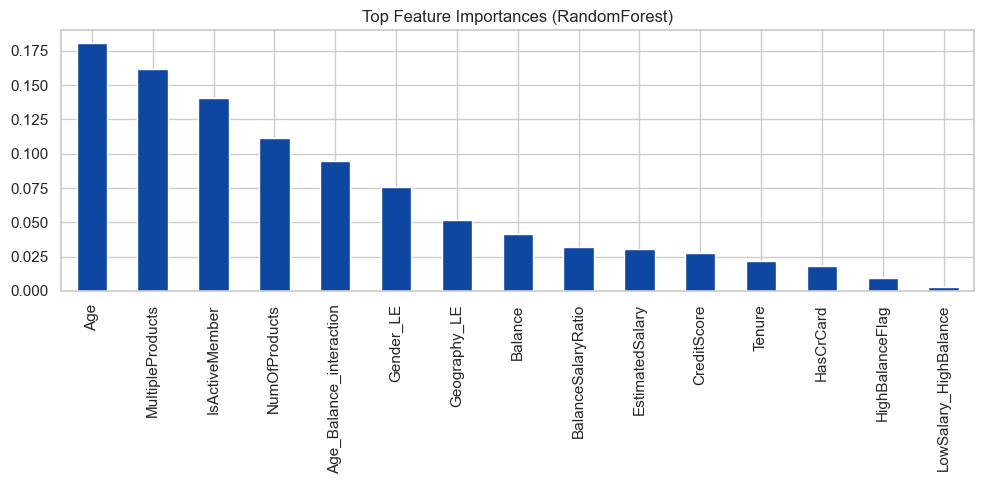

STEP 17 COMPLETED


In [19]:

# 15) Visualizations: Confusion matrices, ROC, Feature importances
# ------------------------------
print("\nSTEP 17: Visualizations - Confusion Matrices, ROC, Feature Importance")

# Confusion matrix - RF
plt.figure(figsize=(5,4))
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("RandomForest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC plot - comparing RF, XGB, ANN
plt.figure(figsize=(7,5))

fpr_rf, tpr_rf, _   = roc_curve(y_test, rf_prob)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_prob)
fpr_ann, tpr_ann, _ = roc_curve(y_test, ann_prob)

# Distinct colors for each model
plt.plot(fpr_rf,  tpr_rf,
         label=f'RF  AUC={auc(fpr_rf, tpr_rf):.3f}',
         color="#1E88E5", linewidth=2)   # bright blue
plt.plot(fpr_xgb, tpr_xgb,
         label=f'XGB AUC={auc(fpr_xgb, tpr_xgb):.3f}',
         color="#FB8C00", linewidth=2)   # vivid orange
plt.plot(fpr_ann, tpr_ann,
         label=f'ANN AUC={auc(fpr_ann, tpr_ann):.3f}',
         color="#43A047", linewidth=2)   # rich green

# Baseline
plt.plot([0, 1], [0, 1], '--', color="#9E9E9E", linewidth=1.5)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Feature importance from RandomForest
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(25)
plt.figure(figsize=(10,5))
fi.plot(kind='bar')
plt.title("Top Feature Importances (RandomForest)")
plt.tight_layout()
plt.show()

print("STEP 17 COMPLETED")


In [20]:

# 18) Hyperparameter tuning example (RandomizedSearchCV for XGBoost)
# ------------------------------
print("\nSTEP 18: Hyperparameter tuning example for XGBoost (RandomizedSearchCV)")
param_dist = {
    'n_estimators':[50,100,200],
    'max_depth':[3,5,7],
    'learning_rate':[0.01,0.05,0.1],
    'subsample':[0.7,0.9,1.0]
}
rs = RandomizedSearchCV(XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
                        param_distributions=param_dist, n_iter=6, cv=3, scoring='roc_auc', random_state=42, n_jobs=1)
rs.fit(X_train_sm, y_train_sm)
print("Best params (XGBoost):", rs.best_params_)
print("Best CV AUC:", rs.best_score_)
print("STEP 18 COMPLETED")


STEP 18: Hyperparameter tuning example for XGBoost (RandomizedSearchCV)
Best params (XGBoost): {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01}
Best CV AUC: 0.9153922958447954
STEP 18 COMPLETED


In [21]:
# ------------------------------
# 19) Final model selection summary
# ------------------------------
print("\nSTEP 19: Summary of model performance (on test set):")
models_summary = pd.DataFrame({
    'model': ['RandomForest','XGBoost','ANN'],
    'accuracy': [accuracy_score(y_test, rf_pred), accuracy_score(y_test, xgb_pred), accuracy_score(y_test, ann_pred)],
    'precision': [precision_score(y_test, rf_pred), precision_score(y_test, xgb_pred), precision_score(y_test, ann_pred)],
    'recall': [recall_score(y_test, rf_pred), recall_score(y_test, xgb_pred), recall_score(y_test, ann_pred)],
    'f1': [f1_score(y_test, rf_pred), f1_score(y_test, xgb_pred), f1_score(y_test, ann_pred)],
    'auc': [auc(fpr_rf,tpr_rf), auc(fpr_xgb,tpr_xgb), auc(fpr_ann,tpr_ann)]
})
display(models_summary)

print("\nPROJECT COMPLETED: Full EDA + Feature Engineering + Modeling Pipeline executed.")


STEP 19: Summary of model performance (on test set):


,model,accuracy,precision,recall,f1,auc
0,RandomForest,0.8135,0.534274,0.651106,0.586932,0.845611
1,XGBoost,0.8275,0.566524,0.648649,0.604811,0.846568
2,ANN,0.8300,0.574610,0.633907,0.602804,0.852985



PROJECT COMPLETED: Full EDA + Feature Engineering + Modeling Pipeline executed.


In [24]:
!pip install -q ydata-profiling
print("ydata-profiling installed successfully.")

ydata-profiling installed successfully.


In [25]:
from ydata_profiling import ProfileReport

# Generate the profile report for the original DataFrame (df)
profile_df = ProfileReport(df, title="EDA Report for Original DataFrame (df)")
profile_df.to_file("df_eda_report.html")

print("EDA report for original DataFrame (df) generated and saved as 'df_eda_report.html'.")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


%|          | 0/14 [00:00<?, ?it/s]
%|▋         | 1/14 [00:00<00:04,  2.81it/s]
100%|██████████| 14/14 [00:00<00:00, 27.89it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

EDA report for original DataFrame (df) generated and saved as 'df_eda_report.html'.


In [26]:
from ydata_profiling import ProfileReport

# Generate the profile report for the feature-engineered DataFrame (df_fe)
profile_df_fe = ProfileReport(df_fe, title="EDA Report for Feature-Engineered DataFrame (df_fe)")
profile_df_fe.to_file("df_fe_eda_report.html")

print("EDA report for feature-engineered DataFrame (df_fe) generated and saved as 'df_fe_eda_report.html'.")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


%|          | 0/26 [00:00<?, ?it/s]
%|█▌        | 4/26 [00:00<00:01, 20.99it/s]
%|██▋       | 7/26 [00:00<00:01, 16.40it/s]
100%|██████████| 26/26 [00:00<00:00, 48.12it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

EDA report for feature-engineered DataFrame (df_fe) generated and saved as 'df_fe_eda_report.html'.
